## Data Part 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import re
from sklearn.model_selection import train_test_split
import os
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def open_file(file):
    data = []
    with open(file,encoding = 'utf-8') as f:
        for line in f.readlines():
            Real=tuple(line.strip().split(sep = "\t")[:2])
            data.append(Real)
    f.close()
    return data

file = open_file("kor.txt")
print(file[:5])

[('Go.', '가.'), ('Hi.', '안녕.'), ('Run!', '뛰어!'), ('Run.', '뛰어.'), ('Who?', '누구?')]


In [3]:
def unicode_to_ascii(s):
    return "".join(c for c in unicodedata.normalize("NFC",s)
                   if unicodedata.category(c) != "Mn")

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

en_sentence = "The sooner you do it, the better it is."
kor_sentence = "더 빨리할수록 좋다."
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(kor_sentence))

<start> the sooner you do it , the better it is . <end>
<start> 더 빨리할수록 좋다 . <end>


In [4]:
def create_datasets(num_examples):
    word_pair = [[preprocess_sentence(s) for s in line] for line in file[:num_examples]]
    return zip(*word_pair)

en,kor = create_datasets(None)
print(en[-1])
print(kor[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> 의심의 여지 없이 세상에는 어떤 남자이든 정확히 딱 알맞는 여자와 결혼하거나 그 반대의 상황이 존재하지 . 그런데 인간이 수백 명의 사람만 알고 지내는 사이가 될 기회를 갖는다고 생각해 보면 , 또 그 수백 명 중 열여 명 쯤 이하만 잘 알 수 있고 , 그리고 나서 그 열여 명 중에 한두 명만 친구가 될 수 있다면 , 그리고 또 만일 우리가 이 세상에 살고 있는 수백만 명의 사람들만 기억하고 있다면 , 딱 맞는 남자는 지구가 생겨난 이래로 딱 맞는 여자를 단 한번도 만난 적이 없을 수도 있을 거라는 사실을 쉽게 눈치챌 수 있을 거야 . <end>


In [5]:
def tokenize(lang):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')
    tokenizer.fit_on_texts(lang)
    
    tensor = tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding = 'post')
    
    return tensor , tokenizer

In [6]:
def load_dataset(num_examples = None):
    tar_lang,inp_lang = create_datasets(None)
    
    input_tensor,input_lang_tokenizer = tokenize(inp_lang)
    target_tensor,target_lang_tokenizer = tokenize(tar_lang)
    return input_tensor,target_tensor, input_lang_tokenizer,target_lang_tokenizer

In [7]:
#Test
num_examples = 1000
input_tensor,target_tensor,input_lang_tokenizer,target_lang_tokenizer = load_dataset(num_examples)

In [8]:
# ALL
input_examples = None
input_tensor,target_tensor,input_lang_tokenizer,target_lang_tokenizer = load_dataset(num_examples)
max_length_tar, max_length_inp = target_tensor.shape[1],input_tensor.shape[1]

In [9]:
#Train_test_split
input_tensor_train, input_tensor_val , target_tensor_train, target_tensor_val = train_test_split(input_tensor,target_tensor,test_size = 0.2)

In [10]:
#Show Length
print("Input_tensor_train : ",len(input_tensor_train))
print("Input_tensor_val : ",len(input_tensor_val))
print("Target_tensor_train : ",len(target_tensor_train))
print("Target_tensor_val : ",len(target_tensor_val))

Input_tensor_train :  2910
Input_tensor_val :  728
Target_tensor_train :  2910
Target_tensor_val :  728


In [11]:
def convert(lang,tensor):
    for t in tensor:
        if t!=0:
            print("%d ----> %s" % (t, lang.index_word[t]))
            
convert(input_lang_tokenizer,input_tensor_train[0])
print()
convert(target_lang_tokenizer,target_tensor_train[0])

1 ----> <start>
18 ----> 네가
284 ----> 아는
161 ----> 사람
950 ----> 중에서
111 ----> 누가
44 ----> 가장
1200 ----> 똑똑한
155 ----> 사람이야
4 ----> ?
2 ----> <end>

1 ----> <start>
73 ----> who
14 ----> s
11 ----> the
184 ----> most
916 ----> intelligent
128 ----> person
7 ----> you
46 ----> know
8 ----> ?
2 ----> <end>


## Model Part

In [12]:
#Initializer
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 16
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(input_lang_tokenizer.word_index)+1
vocab_tar_size = len(target_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [13]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([16, 97]), TensorShape([16, 112]))

In [14]:
#Encoder
#Architecture : Embedding -> GRU + Attention -> 
class Encoder(tf.keras.Model) :
    def __init__(self,vocab_size,embedding_dim,kor_units,batch_sz):
        super(Encoder,self).__init__()
        self.batch_sz = batch_sz
        self.kor_units = kor_units
        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.gru = tf.keras.layers.GRU(self.kor_units,
                                      return_sequences = True,
                                      return_state = True,
                                      recurrent_initializer = "glorot_uniform")
    def call(self,x,hidden):
        x = self.embedding(x)
        output, state = self.gru(x,initial_state = hidden)
        return output,state
    
    def initialize_hidden_state (self):
        return tf.zeros((self.batch_sz,self.kor_units))

In [15]:
encoder = Encoder(vocab_inp_size,embedding_dim,units,BATCH_SIZE)

#sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output,sample_state = encoder(example_input_batch,sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (16, 97, 1024)
Encoder Hidden state shape: (batch size, units) (16, 1024)


In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self,units):
        super(BahdanauAttention,self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self,query,values):
        query_with_time_axis = tf.expand_dims(query,1)
        
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis)+self.W2(values)))
        
        attention_weight = tf.nn.softmax(score,axis = 1)
        context_vector = attention_weight * values
        context_vector = tf.reduce_sum(context_vector,axis = 1)
        
        return context_vector,attention_weight

In [17]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (16, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (16, 97, 1)


In [18]:
class Decoder(tf.keras.Model):
    def __init__(self,vocab_size,embedding_dim,dec_unit,batch_sz):
        super(Decoder,self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_unit
        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                      return_sequences = True,
                                      return_state = True,
                                      recurrent_initializer = 'glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
    
    def call(self,x,hidden,kor_output):
        context_vector,attention_weights = self.attention(hidden,kor_output)
        
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector,1),x],axis = -1)
        output,state = self.gru(x)
        output = tf.reshape(output,(-1,output.shape[2]))
        x = self.fc(output)
        return x,state,attention_weights

In [19]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (16, 2481)


In [20]:
#Define the optimizer and the loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [22]:
@tf.function
def train_step(inp, targ, kor_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        
        kor_output, kor_hidden = encoder(inp, kor_hidden)
        
        dec_hidden = kor_hidden
        
        dec_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, kor_output)
            loss += loss_function(targ[:, t], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [23]:
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()
    kor_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, kor_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.4798
Epoch 1 Batch 100 Loss 0.3742
Epoch 1 Loss 0.3420
Time taken for 1 epoch 193.01 sec

Epoch 2 Batch 0 Loss 0.3656
Epoch 2 Batch 100 Loss 0.3089
Epoch 2 Loss 0.2745
Time taken for 1 epoch 82.25 sec

Epoch 3 Batch 0 Loss 0.2774
Epoch 3 Batch 100 Loss 0.2423
Epoch 3 Loss 0.2422
Time taken for 1 epoch 81.43 sec

Epoch 4 Batch 0 Loss 0.2280
Epoch 4 Batch 100 Loss 0.1818
Epoch 4 Loss 0.2113
Time taken for 1 epoch 82.94 sec

Epoch 5 Batch 0 Loss 0.2015
Epoch 5 Batch 100 Loss 0.2330
Epoch 5 Loss 0.1834
Time taken for 1 epoch 81.87 sec

Epoch 6 Batch 0 Loss 0.1450
Epoch 6 Batch 100 Loss 0.1143
Epoch 6 Loss 0.1559
Time taken for 1 epoch 81.38 sec

Epoch 7 Batch 0 Loss 0.1678
Epoch 7 Batch 100 Loss 0.1113
Epoch 7 Loss 0.1287
Time taken for 1 epoch 80.73 sec

Epoch 8 Batch 0 Loss 0.1058
Epoch 8 Batch 100 Loss 0.0972
Epoch 8 Loss 0.1042
Time taken for 1 epoch 81.29 sec

Epoch 9 Batch 0 Loss 0.0690
Epoch 9 Batch 100 Loss 0.1184
Epoch 9 Loss 0.0813
Time taken for 1 epoch 80

In [24]:
#Evaluate
def evaluate(sentence) :
    attention_plot = np.zeros((max_length_tar,max_length_inp))
    
    #preprocessing
    sentence = preprocess_sentence(sentence)
    
    inputs = [input_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen = max_length_inp,padding = 'post')
    
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1,units))]
    kor_output,kor_hidden = encoder(inputs,hidden)
    
    dec_hidden = kor_hidden
    dec_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']],0)
    
    for t in range(max_length_tar):
        predication,dec_hidden,attention_weight = decoder(dec_input,dec_hidden,kor_output)
        
        attention_weights = tf.reshape(attention_weight,(-1,))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predication[0]).numpy()
        
        result += target_lang_tokenizer.index_word[predicted_id] + ' '
        
        if target_lang_tokenizer.index_word[predicted_id] =='<end>':
            return result,sentence,attention_plot
        
        dec_input = tf.expand_dims([predicted_id],0)
    return result,sentence,attention_plot

In [25]:
def plot_attention(attention,sentence,predicated_sentence):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention,cmap = 'viridis')
    
    fontdict = {'fontsize' : 14}
    
    ax.set_xticklabels(['']+sentence,fontdict = fontdict,rotation = 90)
    ax.set_yticklabels(['']+predicated_sentence,fontdict = fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [26]:
def translate(sentence):
    result,sentence,attention_plot = evaluate(sentence)
    
    print(f"Input : {sentence}")
    print(f"Predicted translation : {result}")
    
    attention_plot = attention_plot[:len(result.split(' ')),:len(sentence.split(' '))]
    plot_attention(attention_plot,sentence.split(' '),result.split(" "))

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
max_length_inp

97

Input : <start> 리눅스는 오픈 소스 소프트웨어야 . <end>
Predicted translation : linux is open source . <end> 


C:\Users\ing_lab\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ing_lab\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45573 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ing_lab\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ing_lab\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ing_lab\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ing_lab\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53944 mi

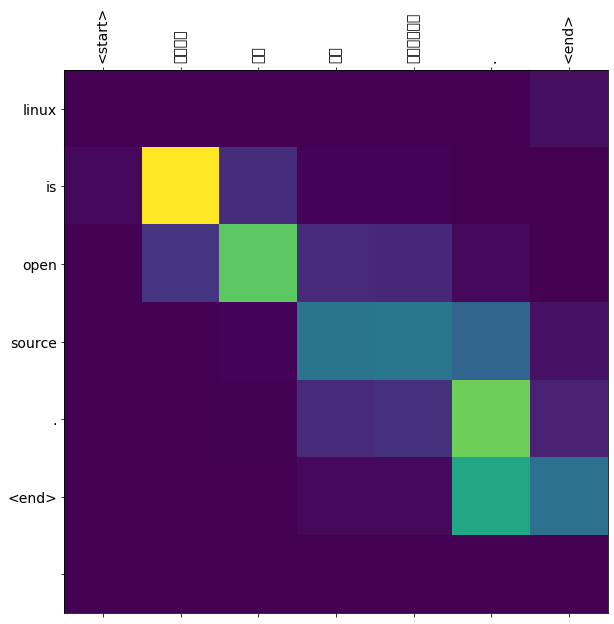

In [39]:
translate('리눅스는 오픈 소스 소프트웨어야.')